# News collector of headers and news full text from thomson reuters eikon terminal

# Imports

## Ordinary imports

In [1]:
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import openpyxl

import os.path
from os import path
import time

from pylab import rcParams
plt.rcParams['figure.figsize'] = 16, 8

In [2]:
# Consistent style for all plots
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

## Eikon import to work with refinitiv eikon API

In [3]:
# Get Started
# https://github.com/Refinitiv-API-Samples/Article.EikonDataAPI.DotNet.Library
# API limits
# https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation?content=49692&type=documentation_item
import eikon as ek

## Import custom function to collect news and prices, work with file system and modelling

In [4]:
import trade_news_predict_prices

# Some constants (path, random seeed, api key)

In [5]:
general_constants = pd.read_csv('general_constants.txt', sep=',', delimiter = ",", header='infer', index_col='variable_name')
general_constants

,value
variable_name,
random_seed,420
directory_path,C:/DAN/t_systems/trade_news
folder_name_headlines,data/backup_headlines/
folder_name_logger,data/logger/
folder_name_merged_news_and_prices,data/merged_news_and_prices/
set_app_key1,ccebd1ff788d4574818be93e35c4741925ac214e
set_app_key2,a8be043d709946238759b0c5cb34c8f90d4e6f2c


In [6]:
# Path to folder with directory is a constant value that stores in .txt
# You can change them in some_constants.txt file or define them on your own.
directory_path = str(general_constants.loc['directory_path'][0])
random_seed = int(general_constants.loc['random_seed'][0])
print(random_seed)
print(directory_path)

420
C:/DAN/t_systems/trade_news


## Set API key

In [8]:
# Set API key to work with thomson reuters data
# Make sure refiniv eikon terminal is running and not disconnected
print(general_constants.loc['set_app_key1'][0])
print(general_constants.loc['set_app_key2'][0])
ek.set_app_key(general_constants.loc['set_app_key2'][0])

ccebd1ff788d4574818be93e35c4741925ac214e
a8be043d709946238759b0c5cb34c8f90d4e6f2c


# Read the df with a list of companies (rics) to get data about them

In [9]:
rics_german_df = pd.read_excel('data/rics_decription/rics_german_excel.xlsx', engine='openpyxl')
sort_cols = ['DAX', 'German_telecom', 'Company Market Cap']
rics_german_df = rics_german_df.sort_values(by=sort_cols, ascending=False) # .reset_index(drop=True)
rics_german_df.index = range(0, len(rics_german_df))
rics_german_df.head(2)

,ric,Company Common Name,Country of Exchange,Primary Country of Risk,TRBC Industry Group Name,TRBC Industry Name,Price Close,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,Germany,Germany,Telecommunications Services,Integrated Telecommunications Services,18.032030,8.580246e+10,1,1
1,SAPG.DE,SAP SE,Germany,Germany,Software & IT Services,Software,122.335901,1.501916e+11,1,0


In [10]:
condition_german = rics_german_df['Country of Exchange'] == 'Germany'
condition_telecom = rics_german_df['TRBC Industry Group Name'] == 'Telecommunications Services'
rics_german_telekom_df = rics_german_df[condition_german & condition_telecom]
print('German telekom companies:', '\n', list(rics_german_telekom_df['ric']))

German telekom companies: 
 ['DTEGn.DE', 'O2Dn.DE', 'UTDI.DE', 'DRIG.DE', 'FNTGn.DE', 'TC1n.DE', 'NFN.DE', 'E4CG.DE', 'PH6.F']


In [11]:
condition_dax = (rics_german_df['DAX'] == 1) & (rics_german_df['German_telecom'] != 1)
rics_dax = rics_german_df[condition_dax]
print('DAX index companies:', '\n', list(rics_dax['ric']))

DAX index companies: 
 ['SAPG.DE', 'SIEGn.DE', 'ALVG.DE', 'VOWG_p.DE', 'DAIGn.DE', 'BASFn.DE', 'ADSGn.DE', 'DPWGn.DE', 'BMWG.DE', 'BAYGn.DE', 'IFXGn.DE', 'HNKG_p.DE', 'VNAn.DE', 'EONGn.DE', 'BEIG.DE', 'CONG.DE', 'RWEG.DE', 'FREG.DE', 'FMEG.DE', 'DBKGn.DE', 'MRCG.DE', 'HEIG.DE', 'CBKG.DE', 'LHAG.DE', 'TKAG.DE', 'PSMGn.DE']


In [12]:
rics_usa_df = pd.read_excel('data/rics_decription/rics_usa_excel.xlsx', engine='openpyxl')
print('Top-50 USA companies by market cap:', '\n', list(rics_usa_df['Company Common Name'])[:50])

Top-50 USA companies by market cap: 
 ['Apple Inc', 'Microsoft Corp', 'Amazon.com Inc', 'Alphabet Inc', 'Tesla Inc', 'Facebook Inc', 'Alibaba Group Holding Ltd', 'Berkshire Hathaway Inc', 'Visa Inc', 'Johnson & Johnson', 'Walmart Inc', 'JPMorgan Chase & Co', 'Mastercard Inc', 'UnitedHealth Group Inc', 'Procter & Gamble Co', 'NVIDIA Corp', 'Walt Disney Co', 'Home Depot Inc', 'PayPal Holdings Inc', 'Bank of America Corp', 'Ishares S&P 500', 'Verizon Communications Inc', 'Comcast Corp', 'Adobe Inc', 'Nike Inc', 'Netflix Inc', 'Pinduoduo Inc', 'Coca-Cola Co', 'Intel Corp', 'Merck & Co Inc', 'Vanguard Idx Fund', 'AT&T Inc', 'Pfizer Inc', 'Salesforce.Com Inc', 'Thermo Fisher Scientific Inc', 'PepsiCo Inc', 'Abbott Laboratories', 'Exxon Mobil Corp', 'Cisco Systems Inc', 'Abbvie Inc', 'Oracle Corp', 'Vanguard 500 Index Fund', 'Broadcom Inc', 'Qualcomm Inc', 'Chevron Corp', 'Accenture PLC', 'Danaher Corp', 'T-Mobile US Inc', 'Costco Wholesale Corp', 'Medtronic PLC']


In [13]:
# Top inductries in the USA file
rics_usa_df[['TRBC Industry Group Name', 'ric']].groupby(['TRBC Industry Group Name']).agg(
    rics_count=('ric', 'count')
).sort_values(by='rics_count', ascending=False).head(5)

,rics_count
TRBC Industry Group Name,
Software & IT Services,303
Biotechnology & Medical Research,257
Banking Services,232
Residential & Commercial REITs,174
Collective Investments,172


# Create all_headlines_df and quasi logger

In [32]:
# Create df which will contain all gathered news

# To get started we can create empty dataframe
trade_news_predict_prices.all_headlines_df = pd.DataFrame(data = [], columns=["ric", "versionCreated", "headline", "storyId", "sourceCode", "story"])

In [15]:
# # But we have created already this not empty df with some news
# # So lets continue to add news to this df
from trade_news_predict_prices import get_name_of_latest_file_in_folder 
latest_file = get_name_of_latest_file_in_folder(general_constants.loc['folder_name_headlines'][0])
trade_news_predict_prices.all_headlines_df = pd.read_csv(latest_file, sep=';')
trade_news_predict_prices.all_headlines_df['versionCreated'] = pd.to_datetime(trade_news_predict_prices.all_headlines_df['versionCreated'])
print(trade_news_predict_prices.all_headlines_df.shape, latest_file)

(399141, 6) data/backup_headlines/all_headlines_df_2021-03-13_v3.csv


In [33]:
# Crate kinda logger

# Empty alternative
trade_news_predict_prices.quasi_logger = pd.DataFrame(data = [], columns=[
    'ric_i', 'ric_now', 'headlines_slice_i', 'headlines_number',
    'up_to_date_ric', 'story_i', 'story_id_now', 'story_is_success', 
    'date_time',
])

In [16]:
# Read the existing logger df instead of creating new empty one.
from trade_news_predict_prices import get_name_of_latest_file_in_folder 
latest_file = get_name_of_latest_file_in_folder(general_constants.loc['folder_name_logger'][0])
trade_news_predict_prices.quasi_logger = pd.read_csv(latest_file, sep=';')
trade_news_predict_prices.quasi_logger['date_time'] = pd.to_datetime(trade_news_predict_prices.quasi_logger['date_time'])
print(trade_news_predict_prices.quasi_logger.shape, latest_file)

c:\python37\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(368542, 11) data/logger/quasi_logger_2021-03-13_v8.csv


# Gather news to all_headlines_df for new rics

In [34]:
from trade_news_predict_prices import get_headlines_and_full_text_news_save 
get_headlines_and_full_text_news_save(
    rics_to_loop_df=rics_usa_df[2000:], # rics_dax, rics_usa_df
    column_name_with_rics='ric',
    column_name_with_dates='versionCreated',
    col_name_with_story_id = 'storyId',
    headlines_count_to_request=100,
    max_num_tries=5,
    dont_collect_such_old_news='2010-01-01',
    save_logger=True,
    save_all_headlines_df=False,
    folder_name_to_save_all_headlines_df=general_constants.loc['folder_name_headlines'][0],
    folder_name_to_save_save_logger=general_constants.loc['folder_name_logger'][0],
)

0 FBC.N

is_this_ric_in_all: False   up_to_date_ric: None got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-06-21 14:38:03.320974 FBC.N  ric_i: 0  headline_slice_i: 1  headline_number: 100  not null: 100 None
(100, 6)

is_this_ric_in_all: True   up_to_date_ric: 2021-04-26 12:09:56.469000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 7

KeyboardInterrupt: 

# What was gathered?

In [35]:
trade_news_predict_prices.all_headlines_df.tail(2)

,ric,versionCreated,headline,storyId,sourceCode,story
1203,JACK.OQ,2020-03-24 20:13:06.561000+00:00,JACK IN THE BOX INC - CO PROVIDED NOTICE THAT ...,urn:newsml:reuters.com:20200324:nFWN2BH1F2:1,NS:RTRS,"<div class=""storyContent"" lang=""en""><style typ..."
1204,JACK.OQ,2020-03-24 20:11:53.471000+00:00,JACK IN THE BOX INC /NEW/ Files -- 8-K,urn:newsml:reuters.com:20200324:nEOL4YGDmg:1,NS:EDG,"<div class=""storyContent"" lang=""en""><p><a href..."


In [36]:
# Show the latest gathered news
index_without_error = len(trade_news_predict_prices.all_headlines_df) - 1
print(index_without_error)
for i in range(0, 100):
    print(index_without_error-i, end=', ')
    if trade_news_predict_prices.all_headlines_df['story'][index_without_error-i] == 'error_when_trying_to_collect_story':
        pass
    else:
        index_without_error = index_without_error - i
        break

trade_news_predict_prices.all_headlines_df[index_without_error-3:index_without_error+3]

1204
1204, 

,ric,versionCreated,headline,storyId,sourceCode,story
1201,JACK.OQ,2020-03-24 22:23:59+00:00,BRIEF-Jack In The Box Provided Notice That It ...,urn:newsml:reuters.com:20200324:nFWN2BH1F2:1,NS:RTRS,"<div class=""storyContent"" lang=""en""><style typ..."
1202,JACK.OQ,2020-03-24 20:13:19.890000+00:00,JACK IN THE BOX INC - SUBSTANTIALLY ALL RESTAU...,urn:newsml:reuters.com:20200324:nFWN2BH1F2:2,NS:RTRS,"<div class=""storyContent"" lang=""en""><style typ..."
1203,JACK.OQ,2020-03-24 20:13:06.561000+00:00,JACK IN THE BOX INC - CO PROVIDED NOTICE THAT ...,urn:newsml:reuters.com:20200324:nFWN2BH1F2:1,NS:RTRS,"<div class=""storyContent"" lang=""en""><style typ..."
1204,JACK.OQ,2020-03-24 20:11:53.471000+00:00,JACK IN THE BOX INC /NEW/ Files -- 8-K,urn:newsml:reuters.com:20200324:nEOL4YGDmg:1,NS:EDG,"<div class=""storyContent"" lang=""en""><p><a href..."


In [37]:
# Choose only rows with collected full news text
print(index_without_error)
trade_news_predict_prices.all_headlines_df = trade_news_predict_prices.all_headlines_df[:index_without_error + 1]

1204


data/backup_headlines/all_headlines_df_2021-06-21_v1.csv


data/logger/quasi_logger_2021-06-21_v6.csv


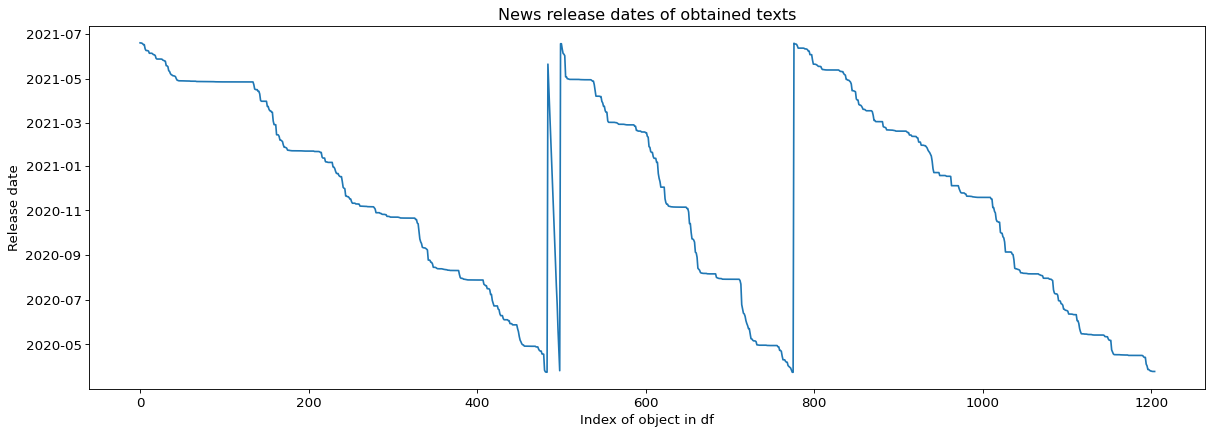

In [40]:
trade_news_predict_prices.all_headlines_df['versionCreated'].plot(figsize=(18,6))
plt.xlabel('Index of object in df')
plt.ylabel('Release date')
plt.title('News release dates of obtained texts')
# plt.grid(True, axis='x')
plt.savefig('exhibits_saved/'+ 'News release dates of obtained texts', bbox_inches = "tight")

# Manually save df with collected news and logger

In [41]:
# Manually save all_headlines_df
from trade_news_predict_prices import save_file_as_new_file_without_replacing 
save_file_as_new_file_without_replacing(
    path_project_folder='',
    folder_name_to_save=general_constants.loc['folder_name_headlines'][0],
    file_to_save=trade_news_predict_prices.all_headlines_df,
    file_short_name_add_to_path='all_headlines_df')

data/backup_headlines/all_headlines_df_2021-06-21_v2.csv


In [42]:
# Сохранить версию логгера вручную
from trade_news_predict_prices import save_file_as_new_file_without_replacing 
save_file_as_new_file_without_replacing(
    path_project_folder='',
    folder_name_to_save=general_constants.loc['folder_name_logger'][0],
    file_to_save=trade_news_predict_prices.quasi_logger,
    file_short_name_add_to_path='quasi_logger')

data/logger/quasi_logger_2021-06-21_v7.csv


# Lines of code to update all_headlines_df with recent news

- `all_headlines_df` will contain absolutely ALL NEWS
- `trade_news_predict_prices.all_headlines_df` will contain recent news

And these recent news will be added to `all_headlines_df` and saved

In [77]:
# Read the file with ALL NEWS
from trade_news_predict_prices import get_name_of_latest_file_in_folder 
latest_file = get_name_of_latest_file_in_folder(general_constants.loc['folder_name_headlines'][0])
all_headlines_df = pd.read_csv(latest_file, sep=';')
all_headlines_df['versionCreated'] = pd.to_datetime(all_headlines_df['versionCreated'])
print(all_headlines_df.shape, latest_file)

(1151, 6) data/backup_headlines/all_headlines_df_2021-06-21_v3.csv


In [78]:
# We create all_headlines_df as a var of module - it will contain recent news
trade_news_predict_prices.all_headlines_df = pd.DataFrame(data = [], columns=["ric", "versionCreated", "headline", "storyId", "sourceCode", "story"])

# Crate kinda logger

# We will use the same logger file
from trade_news_predict_prices import get_name_of_latest_file_in_folder 
latest_file = get_name_of_latest_file_in_folder(general_constants.loc['folder_name_logger'][0])
trade_news_predict_prices.quasi_logger = pd.read_csv(latest_file, sep=';')
trade_news_predict_prices.quasi_logger['date_time'] = pd.to_datetime(trade_news_predict_prices.quasi_logger['date_time'])
print(trade_news_predict_prices.quasi_logger.shape, latest_file)

(1430, 9) data/logger/quasi_logger_2021-06-21_v20.csv


In [79]:
# Some news are already gathered for these rics in trade_news_predict_prices.all_headlines_df
# We can continue gather news from these rics
# up_to_date_not_older_than param controls
existing_rics = pd.DataFrame(data = [], columns=[])
existing_rics['ric'] = list(all_headlines_df.groupby('ric').agg(['count']).index)
print(list(existing_rics['ric']))

['FBC.N', 'HYLS.OQ', 'JACK.OQ', 'STRA.OQ']


`dont_collect_such_old_news` param controls the period of gathering recent news

In [80]:
# Collect only recent news of previously collected companies

from trade_news_predict_prices import get_headlines_and_full_text_news_save 
get_headlines_and_full_text_news_save(
    rics_to_loop_df=existing_rics, # rics_dax, rics_usa_df
    column_name_with_rics='ric',
    column_name_with_dates='versionCreated',
    col_name_with_story_id = 'storyId',
    headlines_count_to_request=20,
    max_num_tries=5,
    dont_collect_such_old_news='2021-06-20',
    save_logger=False,
    save_all_headlines_df=False,
    folder_name_to_save_all_headlines_df=general_constants.loc['folder_name_headlines'][0],
    folder_name_to_save_save_logger=general_constants.loc['folder_name_logger'][0],
)

0 FBC.N

is_this_ric_in_all: False   up_to_date_ric: None got successfully news_get_df.shape: 20
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 
2021-06-21 15:15:46.503054 FBC.N  ric_i: 0  headline_slice_i: 1  headline_number: 20  not null: 20 None
(20, 6)

is_this_ric_in_all: True   up_to_date_ric: 2021-05-28 20:18:53.953000+00:00 data/logger/quasi_logger_2021-06-21_v21.csv
1 HYLS.OQ

is_this_ric_in_all: False   up_to_date_ric: None got successfully news_get_df.shape: 15
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 
2021-06-21 15:16:02.526576 HYLS.OQ  ric_i: 1  headline_slice_i: 1  headline_number: 15  not null: 15 None
(35, 6)
data/logger/quasi_logger_2021-06-21_v22.csv
2 JACK.OQ

is_this_ric_in_all: False   up_to_date_ric: None got successfully news_get_df.shape: 20
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 
2021-06-21 15:16:13.526726 JACK.OQ  ric_i: 2  headline_slice_i: 1  headline_number: 20  not null: 20 None
(55, 6)

is_thi

In [81]:
print('ALL NEWS:')
print('all_headlines_df:', all_headlines_df.shape)
print()
print('Recent news:')
print('trade_news_predict_prices.all_headlines_df:', trade_news_predict_prices.all_headlines_df.shape)


ALL NEWS:
all_headlines_df: (1151, 6)

Recent news:
trade_news_predict_prices.all_headlines_df: (75, 6)


In [82]:
# Add recent news to df with ALL NEWS
print(all_headlines_df.shape, trade_news_predict_prices.all_headlines_df.shape)
all_headlines_df = all_headlines_df.append(trade_news_predict_prices.all_headlines_df, ignore_index=True)
print(all_headlines_df.shape)

# Delete duplicates of ric + storyId
all_headlines_df.drop_duplicates(subset=['ric', 'storyId'], keep='first', inplace=True)
print(all_headlines_df.shape)

(1151, 6) (75, 6)
(1226, 6)
(1151, 6)


# Save all_headlines_df and logger after adding recent news

In [83]:
# Manually save all_headlines_df
from trade_news_predict_prices import save_file_as_new_file_without_replacing 
save_file_as_new_file_without_replacing(
    path_project_folder='',
    folder_name_to_save=general_constants.loc['folder_name_headlines'][0],
    file_to_save=all_headlines_df,
    file_short_name_add_to_path='all_headlines_df')

data/backup_headlines/all_headlines_df_2021-06-21_v4.csv


In [84]:
# Manually save quasi_logger
from trade_news_predict_prices import save_file_as_new_file_without_replacing 
save_file_as_new_file_without_replacing(
    path_project_folder='',
    folder_name_to_save=general_constants.loc['folder_name_logger'][0],
    file_to_save=trade_news_predict_prices.quasi_logger,
    file_short_name_add_to_path='quasi_logger')

data/logger/quasi_logger_2021-06-21_v25.csv
